In [1]:
from ml.nodes import *
from ml.traces import *
import tensorflow as tf

In [2]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
                                   MNIST:        0     N:-1 C:784 


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [4]:
x = ds.x
y_ = ds.y_

In [5]:
x_im = Reshape(ds, 'C', 'WHC', (28, 28, 1))

c = Conv2d(x_im, 5, 32)
b = Bias(c)
relu = Relu(b)
mp1 = MaxPool(relu, 2, stride=2)

c2 = Conv2d(mp1, 5, 64)
b2 = Bias(c2)
relu2 = Relu(b2)
mp2 = MaxPool(relu2, 2, stride=2)

f3 = Flatten(mp2)
l3 = Linear(f3, 1024)
b3 = Bias(l3)
r3 = Relu(b3)

keep_prob = tf.placeholder(tf.float32)
d4 = Dropout(r3, keep_prob)
l4 = Linear(d4, 10)
b4 = Bias(l4)

s = SoftmaxCrossEntropyWithLogits(b4, y_)
sm = Softmax(b4)
ce = Mean(s)

acc = Accuracy(b4, y_)

                                 Reshape:        0     N:-1 W:28 H:28 C:1 
                                  Conv2d:      800     N:-1 W:28 H:28 C:32 
                                    Bias:       32     N:-1 W:28 H:28 C:32 
                                    Relu:        0     N:-1 W:28 H:28 C:32 
                                 MaxPool:        0     N:-1 W:14 H:14 C:32 
                                  Conv2d:    51200     N:-1 W:14 H:14 C:64 
                                    Bias:       64     N:-1 W:14 H:14 C:64 
                                    Relu:        0     N:-1 W:14 H:14 C:64 
                                 MaxPool:        0     N:-1 W:7 H:7 C:64 
                                 Flatten:        0     N:-1 C:3136 
                                  Linear:  3211264     N:-1 C:1024 
                                    Bias:     1024     N:-1 C:1024 
                                    Relu:        0     N:-1 C:1024 
                                 Dropout:      

In [6]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(ce.out())
sess.run(tf.global_variables_initializer())

In [7]:
trackables = [ [ ScalarTrace(acc.out(), 'Accuracy',      yFn='log', skip=100),
                 ScalarTrace(ce.out(),  'Cross Entropy', yFn='log', skip=100), ],
               [ BiasTrace(b.b, 'Conv1 Bias'),  WeightTrace(c.W, 'Conv1 Weights'),   OutTrace(b.out(), 'Out')],
               [ BiasTrace(b2.b, 'Conv2 Bias'), WeightTrace(c2.W, 'Conv2 Weights'),  OutTrace(b2.out(), 'Out')],
               [ BiasTrace(b3.b, 'Lin1 Bias'),  WeightTrace(l3.W, 'Lin1 Weights'),   OutTrace(b3.out(), 'Out')],
               [ BiasTrace(b4.b, 'Lin2 Bias'),  WeightTrace(l4.W, 'Lin2 Weights'),   OutTrace(b4.out(), 'Out')],
               [ OutTrace(sm.out(), 'Softmax'),
                 TopTrace(sm.out(), 'Softmax/Top'),
                 TopTrace(sm.out(), 'Softmax/2nd', index=-2), ],
             ]

track = Track(trackables)

In [8]:
def train(track, epochs=200):
    nodes = track.nodes()
    for i in range(epochs):
        for j in range(100):
            batch = ds.train.next_batch(50)
            vals = sess.run([train_step] + nodes, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
            track.addBatch(vals[1:])
        r = sess.run(nodes, feed_dict={x: ds.validation.images(), y_: ds.validation.labels(), keep_prob: 1.0})
        print '%4d' % i,
        if (i+1) % 10 == 0:
            print '%8.04f' % (r[0]*100)
        track.addEpoch(r)
        
train(track)

   0    1    2    3    4    5    6    7    8    9  96.1800
  10   11   12   13   14   15   16   17   18   19  97.4800
  20   21   22   23   24   25   26   27   28   29  98.2000
  30   31   32   33   34   35   36   37   38   39  98.4600
  40   41   42   43   44   45   46   47   48   49  98.6600
  50   51   52   53   54   55   56   57   58   59  98.8800
  60   61   62   63   64   65   66   67   68   69  98.7200
  70   71   72   73   74   75   76   77   78   79  99.0000
  80   81   82   83   84   85   86   87   88   89  99.0000
  90   91   92   93   94   95   96   97   98   99  99.0600
 100  101  102  103  104  105  106  107  108  109  99.1000
 110  111  112  113  114  115  116  117  118  119  99.1200
 120  121  122  123  124  125  126  127  128  129  99.2000
 130  131  132  133  134  135  136  137  138  139  99.1400
 140  141  142  143  144  145  146  147  148  149  99.2200
 150  151  152  153  154  155  156  157  158  159  99.1600
 160  161  162  163  164  165  166  167  168  169  99.18

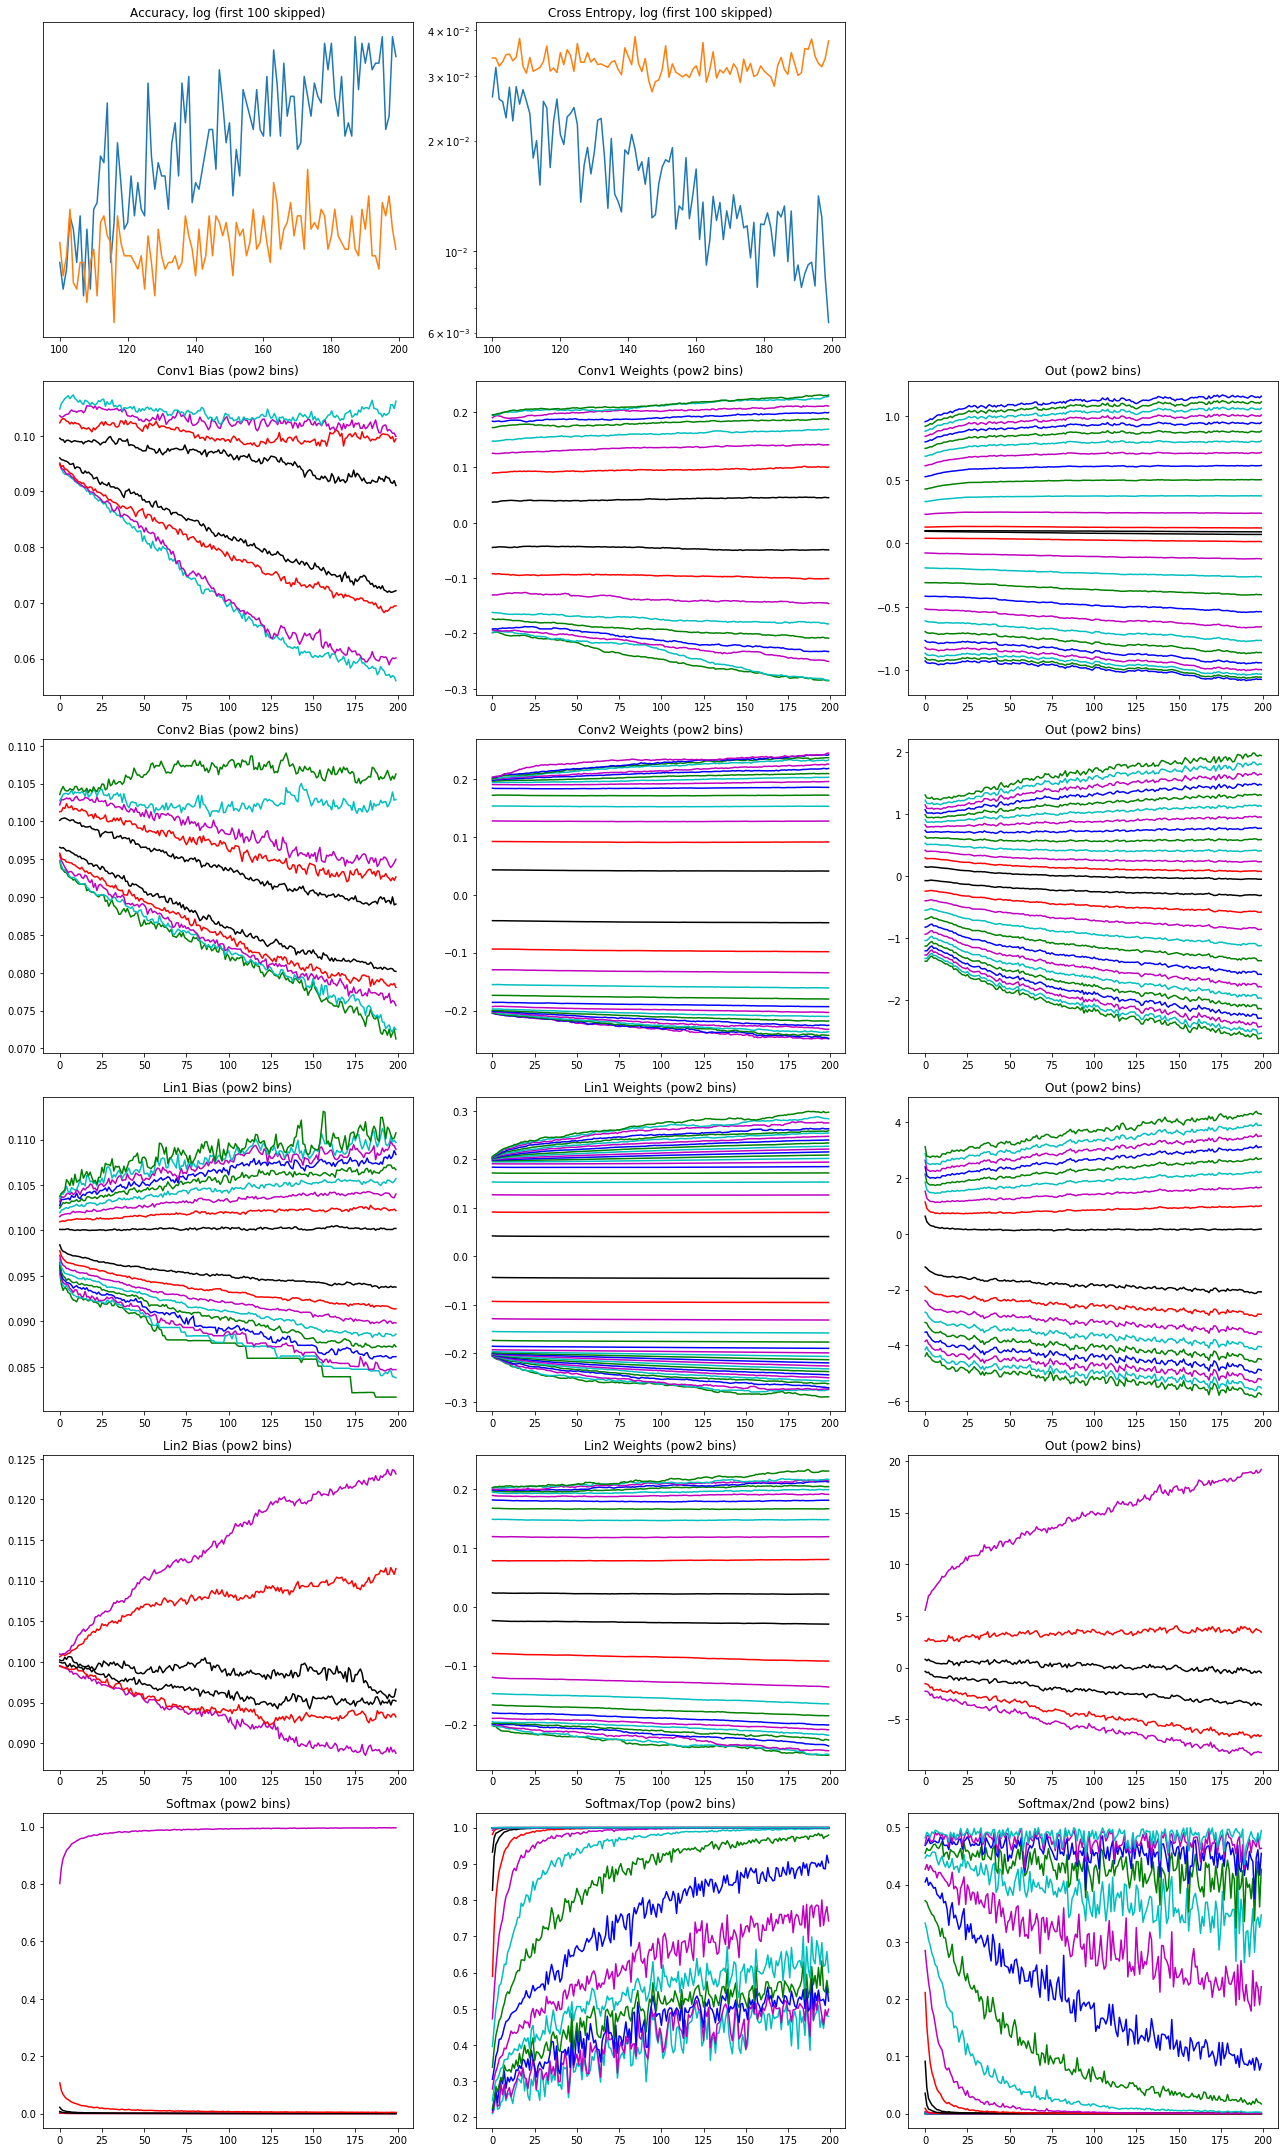

In [9]:
track.plotAll(width=18, height=30)

In [10]:
print("test accuracy %g" % 
          acc.out().eval(
            feed_dict={ x: ds.test.images(), y_: ds.test.labels(), keep_prob: 1.0}))

test accuracy 0.9917
